In [1]:
from scipy.stats import multivariate_normal
import pybnb
from functools import partial
from sklearn.ensemble import IsolationForest

%load_ext autoreload
%autoreload 2

from BranchAndBoundSolver import BranchAndBoundSolver

In [2]:
training_points = multivariate_normal.rvs(size=(200,2))
point_to_be_classified = training_points[0]

In [3]:
problem = BranchAndBoundSolver(training_points, point_to_be_classified)
solver = pybnb.Solver(comm=None)
results = solver.solve(problem, absolute_gap=0.05, queue_strategy="bound")


Using non-default solver options:
 - absolute_gap: 0.05 (default: 0)

Starting branch & bound solve:
 - dispatcher pid: 61465 (MacBook-Pro.fritz.box)
 - worker processes: 1
---------------------------------------------------------------------------------------------------------------------
         Nodes        |                   Objective Bounds                     |              Work              
      Expl    Unexpl  |      Incumbent           Bound    Rel. Gap    Abs. Gap | Time (s)  Nodes/Sec Imbalance   Idle
         0         1  |            inf            -inf         inf%        inf |      0.0       0.00     0.00%      0
*        1         0  |     0.03691726           0.005    3.191726%    0.03192 |      0.0     361.14     0.00%      0
---------------------------------------------------------------------------------------------------------------------

Absolute optimality tolerance met
Optimal solution found!

solver results:
 - solution_status: optimal
 - termination_cond

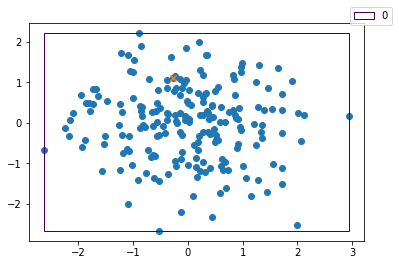

In [4]:
from matplotlib import pyplot as plt
import matplotlib.patches as patches
%matplotlib inline
cmap = plt.colormaps['viridis']
def draw2dpattern(interval, ax, index, total):
    ax.add_patch(patches.Rectangle(
        xy=(interval[0,0], interval[1,0]),
        width=interval[0,1] - interval[0,0],
        height=interval[1,1] - interval[1,0],
        facecolor='none',
        edgecolor=cmap(index/total),
        label=index
    )
    )


plt.scatter(x=training_points[:,0], y=training_points[:,1])
plt.scatter(x=point_to_be_classified[0], y=point_to_be_classified[1], marker="x")
ax = plt.gca()
total = len(problem.trajectory)
for i, interval in enumerate(problem.trajectory):
    draw2dpattern(interval, ax, i, total)
ax.legend(bbox_to_anchor=(1.1, 1.1))
plt.show()

## Implementing PAC-RPAD algorithm.

In [2]:
from typing import Callable
import numpy as np
from patterns import AxisAlignedHyperRectangle, find_bounding_pattern

class PACRPAD:
    """
    Superclass for all PAC-RPAD implementations
    """
    def __init__(self, tau, epsilon, delta):
        self.tau = tau
        self.epsilon = epsilon
        self.delta = delta
        self.find_min_f_hat: Callable[[np.ndarray], float] = lambda *_: 0. #this function should be provided by each subclass based on training data

    def has_rare_pattern(self, point):
        return self.find_min_f_hat(point) <= self.tau + self.epsilon / 2

In [3]:

class AxisAlignedHyperRectanglePACRPAD(PACRPAD):
    def __init__(self, tau, epsilon, delta):
        super(AxisAlignedHyperRectanglePACRPAD).__init__(tau, epsilon, delta)
        self.solver = None

    def construct_f_hat_estimator(self, training_data, absolute_gap=0.01, queue_strategy="bound"):
        self.solver = partial(BranchAndBoundSolver, training_data = training_data)
        super().find_min_f_hat = lambda point: pybnb.Solver(comm=None).solve(self.solver(point_to_be_classified = point),
                                                                             absolute_gap=absolute_gap,
                                                                             queue_strategy=queue_strategy
                                                                             )

class RandomForestApproximatePACRPAD(PACRPAD):
    def __init__(self, tau, epsilon, delta):
        super(RandomForestApproximatePACRPAD).__init__(tau, epsilon, delta)
        self.random_forest = None

    def construct_f_hat_estimator(self, training_data):
        self.random_forest = IsolationForest(random_state=0).fit(training_data)
        bounding_pattern = find_bounding_pattern(training_data)

        def find_pattern_in_tree(tree, point:np.array):
            features = tree.feature
            thresholds = tree.threshold
            intervals = bounding_pattern.intervals

            point = point.reshape(1,-1)
            node_index = tree.decision_path(point).indices[0]

            while len(node_index) > 0:
                node_id = node_index.pop()
                f = features[node_id]
                t = thresholds[node_id]
                intervals[point[f] > t,f] = t

            return tree.n_node_samples[node_index], AxisAlignedHyperRectangle(intervals)

        def evaluate_f_hat(tree, point):
            samples, pattern = find_pattern_in_tree(tree, point)
            return (samples * bounding_pattern.area)/(pattern.area * len(training_data))

        super().find_min_f_hat = lambda point : min([evaluate_f_hat(estimator.tree_, point) for estimator in self.random_forest.estimators_])


In [12]:
training_points = multivariate_normal.rvs(size=(200,2))
rf = IsolationForest().fit(training_points)

array([ 0,  0, -2,  0,  1, -2, -2,  1,  0,  0,  0,  0, -2, -2,  1, -2, -2,
        1, -2,  0, -2, -2,  1,  0,  0, -2, -2, -2,  0,  1, -2, -2,  1, -2,
       -2,  1, -2,  1, -2,  1, -2, -2,  0,  1,  1,  0,  1, -2,  0,  0, -2,
       -2, -2,  0,  1, -2, -2,  1, -2, -2,  1, -2, -2,  1,  1,  0,  1,  1,
       -2, -2,  0, -2, -2,  0,  0, -2, -2,  1, -2, -2,  0, -2,  1,  0, -2,
       -2,  1, -2, -2,  1, -2,  1, -2, -2,  1,  0,  1, -2,  1,  0,  0, -2,
       -2,  0, -2, -2, -2,  1, -2,  1,  1,  0, -2, -2, -2,  1,  0, -2, -2,
       -2, -2], dtype=int64)

[Text(0.3362198795180723, 0.9444444444444444, 'X[0] <= -1.94\nsquared_error = 0.087\nsamples = 200\nvalue = 0.469'),
 Text(0.024096385542168676, 0.8333333333333334, 'X[0] <= -2.616\nsquared_error = 0.047\nsamples = 7\nvalue = 0.535'),
 Text(0.012048192771084338, 0.7222222222222222, 'squared_error = 0.0\nsamples = 1\nvalue = 0.254'),
 Text(0.03614457831325301, 0.7222222222222222, 'X[1] <= -1.217\nsquared_error = 0.039\nsamples = 6\nvalue = 0.581'),
 Text(0.024096385542168676, 0.6111111111111112, 'squared_error = 0.0\nsamples = 1\nvalue = 0.565'),
 Text(0.04819277108433735, 0.6111111111111112, 'X[1] <= 0.707\nsquared_error = 0.047\nsamples = 5\nvalue = 0.585'),
 Text(0.03614457831325301, 0.5, 'X[0] <= -2.324\nsquared_error = 0.055\nsamples = 4\nvalue = 0.612'),
 Text(0.024096385542168676, 0.3888888888888889, 'squared_error = 0.0\nsamples = 1\nvalue = 0.909'),
 Text(0.04819277108433735, 0.3888888888888889, 'X[0] <= -2.05\nsquared_error = 0.034\nsamples = 3\nvalue = 0.513'),
 Text(0.036144

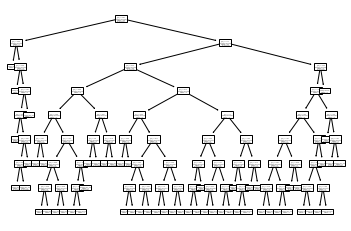

In [48]:
from sklearn import tree
tree.plot_tree(rf.estimators_[0])

In [19]:
print(rf.estimators_[0].decision_path(training_points[0].reshape(1, -1)))


  (0, 0)	1
  (0, 42)	1
  (0, 43)	1
  (0, 63)	1
  (0, 64)	1
  (0, 65)	1
  (0, 66)	1
  (0, 70)	1
  (0, 71)	1


In [20]:
rf.estimators_[0].apply(training_points[0].reshape(1, -1))

array([71])

In [18]:
node_indicator = rf.estimators_[0].decision_path(training_points[0].reshape(1, -1))
sample_id = 0
# obtain ids of the nodes `sample_id` goes through, i.e., row `sample_id`
node_index = node_indicator.indices[0]
             # node_indicator.indptr[sample_id] : node_indicator.indptr[sample_id + 1]
             # ]

In [16]:
node_index

array([ 0, 42, 43, 63, 64, 65, 66, 70, 71], dtype=int32)

In [8]:
training_points[0].reshape(1, -1).shape

(1, 2)